Importing libraries

In [1]:
from tensorflow import keras
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt

Utility functions

In [2]:
def normalize_array(array: np.array) -> np.array:
  # Normalizes array between 0 and 1

  max = np.max(array)
  min = np.min(array)

  return (array - min) / (max - min)


def shuffle_visual_field_dataset(x_data: np.array, y_data: np.array) -> Tuple[np.array, np.array]:
  # shuffles dataset comprised of two arrays

  n = len(y_data)
  unique_indices = np.random.permutation(n) # generates random permutation of list in range(0, n)
  x_data = x_data[unique_indices]
  y_data = y_data[unique_indices]

  return x_data, y_data


def shuffle_two_visual_fields_dataset(x_data_left: np.array, x_data_right: np.array, y_data: np.array) -> Tuple[np.array, np.array, np.array]:
  # Shuffles dataset comprised of three arrays

  n = len(y_data)
  unique_indices = np.random.permutation(n) # generates random permutation of list in range(0, n)
  x_data_left = x_data_left[unique_indices]
  x_data_right = x_data_right[unique_indices]
  y_data = y_data[unique_indices]

  return x_data_left, x_data_right, y_data


def shuffle_and_double_dataset(x_data: np.array, y_data: np.array) -> Tuple[np.array, np.array]:
  x_data1, y_data1 = shuffle_visual_field_dataset(x_data, y_data)
  x_data2, y_data2 = shuffle_visual_field_dataset(x_data, y_data)

  x_data_concatenated = np.concatenate((x_data1, x_data2))
  y_data_concatenated = np.concatenate((y_data1, y_data2))

  return x_data_concatenated, y_data_concatenated


def build_visual_field_data(x_data: np.array, y_data: np.array, n: float) -> Tuple[np.array, np.array]:
  '''
  Builds the dataset for a single visual field, choosing random values from the input.

  Input:
  x_data: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset.
  y_data: np.array(int): corresponding value of the digit represented by x_data.
  n: float: size of the final dataset

  Output:
  x_data_right: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset.
  y_data: np.array(int): corresponding value of the digit of the visual field.
  '''

  original_size = len(y_data)
  random_indices = np.random.choice(np.arange(0, original_size), n)
  x_data_visual_field = x_data[random_indices]
  y_data_visual_field = y_data[random_indices]

  return x_data_visual_field, y_data_visual_field


def build_double_visual_fields_dataset(x_data: np.array, y_data: np.array, final_size: float = 4, proportion_cs: float = 0.5, proportion_left: float = 0.5, full_attention_value: float = 1, reduced_attention_value: float = 0.5, ss_attention_value: float = 0.5) -> Tuple[np.array, np.array, np.array]:
  '''
  Builds an entire double visual fields dataset, comprised of two visual fields, left and right, and an array of the corresponding answer value for both visual fields.

  Input:
  x_data: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset.
  y_data: np.array(int): corresponding value of the digit represented by x_data.
  final_size: float: how many times the final dataset is bigger than the input data. Default is 4.
  proportion_cs: float: proportion of entries in the final dataset that have CS over SS. Default is 0.5.
  proportion_left: float: proportion of entries in the final dataset that have attention on the left visual field. Default is 0.5.
  full_attention_value: float: value of the full attention in CS. Default is 1.
  reduced_attention_value: float: value of the reduced attention in CS. Default is 0.5.
  ss_attention_value: float: value of the attention for SS. Default is 0.5.

  Output:
  x_data_left: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset with a determined attention.
  x_data_right: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset with a determined attention.
  y_data: np.array(int): corresponding value of the digit that has most attention considering both visual fields.
  '''

  n = len(y_data) * final_size
  x_data_left, y_data_left = build_visual_field_data(x_data, y_data, n)
  x_data_right, y_data_right = build_visual_field_data(x_data, y_data, n)

  y_data_final = np.zeros(n)
  for i in range(n):
    data_with_cs = np.random.choice([False, True], p=[1 - proportion_cs, proportion_cs])
    data_with_left_attention = np.random.choice([False, True], p=[1 - proportion_left, proportion_left])

    # determines value of attention if dataset entry is CS or SS
    if data_with_cs:
      attention = full_attention_value
      no_attention = reduced_attention_value
    else:
      attention = ss_attention_value
      no_attention = 0

    # determines which visual field has attention
    if data_with_left_attention:
        x_data_left[i] *= attention
        x_data_right[i] *= no_attention
        y_data_final[i] = y_data_left[i]
    else:
        x_data_left[i] *= no_attention
        x_data_right[i] *= attention
        y_data_final[i] = y_data_right[i]

  return x_data_left, x_data_right, y_data_final

def show_dataset(x_data_left: np.array, x_data_right: np.array, y_data: np.array, num_images: int) -> None:
  fig1, ax = plt.subplots(num_images, 2, figsize=(2.4, num_images * 1.2))
  for i in range(num_images):
    ax[i,0].imshow(x_data_left[i], cmap="binary", vmax=1)
    ax[i,1].imshow(x_data_right[i], cmap="binary", vmax=1)
    ax[i,1].text(45, 18, '%d'%(y_data[i]), fontsize=20)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
  plt.show()



Importing dataset and normalizing input

In [3]:
mnist_dataset = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()
x_train = normalize_array(x_train)
x_test = normalize_array(x_test)


11490434/11490434 [==============================] - 0s 0us/step


Building training dataset

In [4]:
x_train_left, x_train_right, y_train_final = build_double_visual_fields_dataset(
    x_train, y_train, final_size=4, proportion_cs=0.5, proportion_left=0.5, full_attention_value=1, reduced_attention_value=0.5, ss_attention_value=0.5)

Showing training dataset

[0. 6. 9. ... 3. 5. 9.]


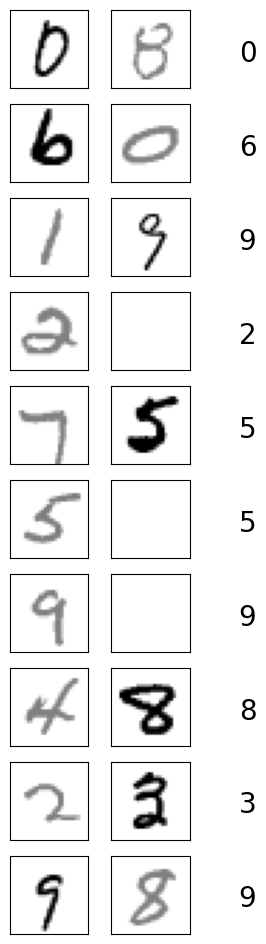

In [5]:
print(y_train_final)
show_dataset(x_train_left, x_train_right, y_train_final, 10)

Building testing dataset

In [5]:
x_test_left, x_test_right, y_test_final = build_double_visual_fields_dataset(
    x_test, y_test, final_size=4, proportion_cs=0.5, proportion_left=0.5, full_attention_value=1, reduced_attention_value=0.5, ss_attention_value=0.5)

Show testing dataset

[6. 7. 7. ... 2. 7. 0.]


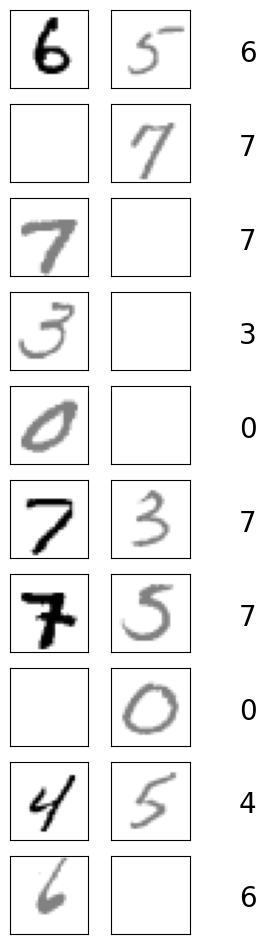

In [7]:
print(y_test_final)
show_dataset(x_test_left, x_test_right, y_test_final, 10)

To save RAM

In [6]:
del x_train, y_train, x_test, y_test

Simple Neural Network

In [6]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300,activation="relu"))
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(10,activation="softmax"))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 

In [9]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [10]:
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
1875/1875 [==============================] - 11s 5ms/step - loss: 0.8965 - accuracy: 0.7173 - val_loss: 0.3419 - val_accuracy: 0.9064
Epoch 2/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4510 - accuracy: 0.8666 - val_loss: 0.2620 - val_accuracy: 0.9224
Epoch 3/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3614 - accuracy: 0.8936 - val_loss: 0.2146 - val_accuracy: 0.9372
Epoch 4/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3126 - accuracy: 0.9096 - val_loss: 0.1879 - val_accuracy: 0.9451
Epoch 5/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2753 - accuracy: 0.9199 - val_loss: 0.1699 - val_accuracy: 0.9476
Epoch 6/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2521 - accuracy: 0.9269 - val_loss: 0.1565 - val_accuracy: 0.9521
Epoch 7/50
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2322 - accuracy: 0.9328 - val_loss: 0.1416 - val_accur

Two Visual Fields Neural Network



FUSION (CONCATENATION) AFTER THE SECOND LAYER

In [6]:
input_L    = keras.layers.Input(shape=[28,28], name="left_input")
flatten_L  = keras.layers.Flatten()(input_L)
hidden1_L  = keras.layers.Dense(300,activation="relu")(flatten_L)
drop1_L    = keras.layers.Dropout(rate=0.4)(hidden1_L)
hidden2_L  = keras.layers.Dense(100,activation="relu")(drop1_L)
drop2_L    = keras.layers.Dropout(rate=0.4)(hidden2_L)

input_R    = keras.layers.Input(shape=[28,28], name="right_input")
flatten_R  = keras.layers.Flatten()(input_R)
hidden1_R  = keras.layers.Dense(300,activation="relu")(flatten_R)
drop1_R    = keras.layers.Dropout(rate=0.4)(hidden1_R)
hidden2_R  = keras.layers.Dense(100,activation="relu")(drop1_R)
drop2_R    = keras.layers.Dropout(rate=0.4)(hidden2_R)

concat_LR     = keras.layers.concatenate([drop2_L,drop2_R])
output_LR     = keras.layers.Dense(10,activation="softmax")(concat_LR)

model_LR_FH2    = keras.Model(inputs=[input_L,input_R],outputs=[output_LR] )

In [7]:
model_LR_FH2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 left_input (InputLayer)     [(None, 28, 28)]             0         []                            
                                                                                                  
 right_input (InputLayer)    [(None, 28, 28)]             0         []                            
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['left_input[0][0]']          
                                                                                                  
 flatten_1 (Flatten)         (None, 784)                  0         ['right_input[0][0]']         
                                                                                              

In [8]:
model_LR_FH2.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [9]:
history_LR_FH2 = model_LR_FH2.fit((x_train_left, x_train_right), y_train_final, epochs=50, validation_data=((x_test_left, x_test_right), y_test_final))

Epoch 1/50
7500/7500 [==============================] - 41s 5ms/step - loss: 1.0122 - accuracy: 0.7031 - val_loss: 0.4776 - val_accuracy: 0.8820
Epoch 2/50
7500/7500 [==============================] - 32s 4ms/step - loss: 0.5814 - accuracy: 0.8466 - val_loss: 0.3629 - val_accuracy: 0.9101
Epoch 3/50
7500/7500 [==============================] - 38s 5ms/step - loss: 0.4773 - accuracy: 0.8780 - val_loss: 0.3034 - val_accuracy: 0.9255
Epoch 4/50
7500/7500 [==============================] - 31s 4ms/step - loss: 0.4129 - accuracy: 0.8963 - val_loss: 0.2612 - val_accuracy: 0.9364
Epoch 5/50
7500/7500 [==============================] - 37s 5ms/step - loss: 0.3671 - accuracy: 0.9096 - val_loss: 0.2365 - val_accuracy: 0.9432
Epoch 6/50
7500/7500 [==============================] - 36s 5ms/step - loss: 0.3361 - accuracy: 0.9176 - val_loss: 0.2169 - val_accuracy: 0.9480
Epoch 7/50
7500/7500 [==============================] - 42s 6ms/step - loss: 0.3085 - accuracy: 0.9260 - val_loss: 0.2008 - val_ac

FUSION (CONCATENATION) AFTER THE FIRST HIDDEN LAYER

In [6]:
input_L    = keras.layers.Input(shape=[28,28], name="left_input")
flatten_L  = keras.layers.Flatten()(input_L)
hidden1_L  = keras.layers.Dense(300,activation="relu")(flatten_L)
drop1_L    = keras.layers.Dropout(rate=0.4)(hidden1_L)

input_R    = keras.layers.Input(shape=[28,28], name="right_input")
flatten_R  = keras.layers.Flatten()(input_R)
hidden1_R  = keras.layers.Dense(300,activation="relu")(flatten_R)
drop1_R    = keras.layers.Dropout(rate=0.4)(hidden1_R)

concat_LR     = keras.layers.concatenate([drop1_L,drop1_R])
hidden2_LR  = keras.layers.Dense(100,activation="relu")(concat_LR)
drop2_LR    = keras.layers.Dropout(rate=0.4)(hidden2_LR)
output_LR     = keras.layers.Dense(10,activation="softmax")(drop2_LR)

model_LR_FH1    = keras.Model(inputs=[input_L,input_R],outputs=[output_LR])

In [7]:
model_LR_FH1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 left_input (InputLayer)     [(None, 28, 28)]             0         []                            
                                                                                                  
 right_input (InputLayer)    [(None, 28, 28)]             0         []                            
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['left_input[0][0]']          
                                                                                                  
 flatten_1 (Flatten)         (None, 784)                  0         ['right_input[0][0]']         
                                                                                              

In [8]:
model_LR_FH1.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [9]:
history_LR_FH1 = model_LR_FH1.fit((x_train_left, x_train_right), y_train_final, epochs=50, validation_data=((x_test_left, x_test_right), y_test_final))

Epoch 1/50
7500/7500 [==============================] - 31s 4ms/step - loss: 0.9397 - accuracy: 0.7195 - val_loss: 0.4176 - val_accuracy: 0.8828
Epoch 2/50
7500/7500 [==============================] - 26s 3ms/step - loss: 0.4948 - accuracy: 0.8560 - val_loss: 0.2904 - val_accuracy: 0.9162
Epoch 3/50
7500/7500 [==============================] - 25s 3ms/step - loss: 0.3858 - accuracy: 0.8873 - val_loss: 0.2313 - val_accuracy: 0.9318
Epoch 4/50
7500/7500 [==============================] - 26s 3ms/step - loss: 0.3217 - accuracy: 0.9049 - val_loss: 0.1949 - val_accuracy: 0.9421
Epoch 5/50
7500/7500 [==============================] - 25s 3ms/step - loss: 0.2810 - accuracy: 0.9177 - val_loss: 0.1706 - val_accuracy: 0.9496
Epoch 6/50
7500/7500 [==============================] - 26s 3ms/step - loss: 0.2487 - accuracy: 0.9273 - val_loss: 0.1524 - val_accuracy: 0.9546
Epoch 7/50
7500/7500 [==============================] - 25s 3ms/step - loss: 0.2270 - accuracy: 0.9336 - val_loss: 0.1376 - val_ac

Showing Model Predictions

In [14]:
def PlotTest(n,m,model,w1,w2,testdata):
  XX1 = testdata[n:n+1]
  XX2 = testdata[m:m+1]
  y_predXX = model.predict((w1*XX1,w2*XX2))
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(w1*XX1[0],cmap="binary",vmax=1)
  ax2.imshow(w2*XX2[0],cmap="binary",vmax=1)
#plt.axis("off")
  fig = plt.figure(figsize = (6, 3))
# creating the bar plot
  seq = np.array([i for i in range(10)])
  plt.bar(seq,y_predXX[0], color ='maroon',width=1)
  plt.xlabel("Character")
  plt.ylabel("Probability")
  plt.title("Network output")
  plt.show()

1/1 [==============================] - 0s 108ms/step


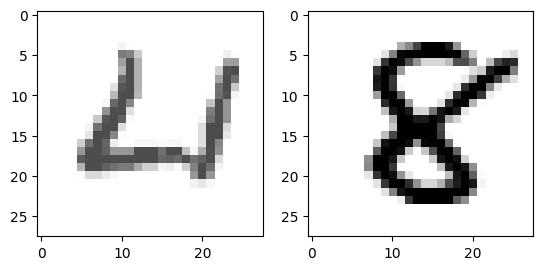

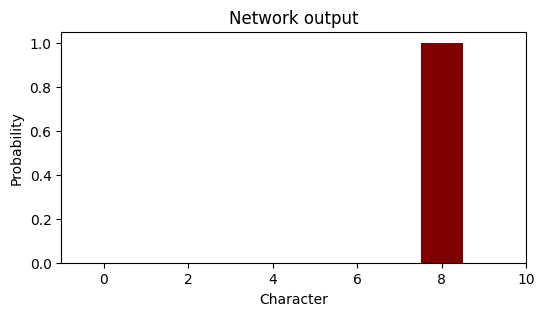

In [15]:
PlotTest(33,3198,model_LR_FH1,0.7,1,x_test)

1/1 [==============================] - 0s 72ms/step


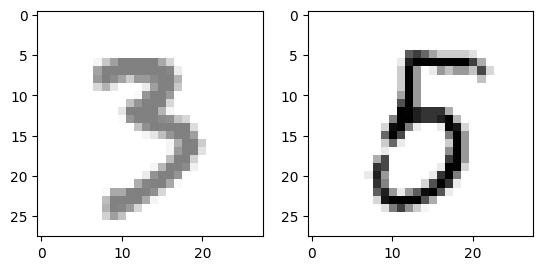

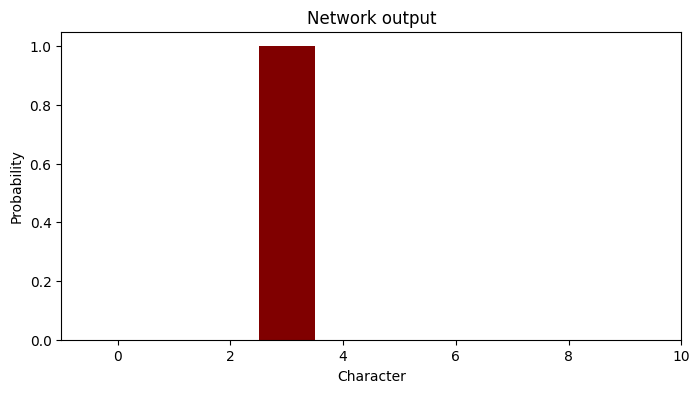

In [16]:
XX1 = x_test[30:31]
XX2 = x_test[45:46]

y_predXX = model_LR_FH2.predict((0.7*XX1,0*XX2))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(0.5*XX1[0],cmap="binary",vmax=1)
ax2.imshow(XX2[0],cmap="binary",vmax=1)
#plt.axis("off")
fig = plt.figure(figsize = (8, 4))

# creating the bar plot
seq = np.array([i for i in range(10)])
plt.bar(seq,y_predXX[0], color ='maroon',width=1)

plt.xlabel("Character")
plt.ylabel("Probability")
plt.title("Network output")
plt.show()

1/1 [==============================] - 0s 36ms/step


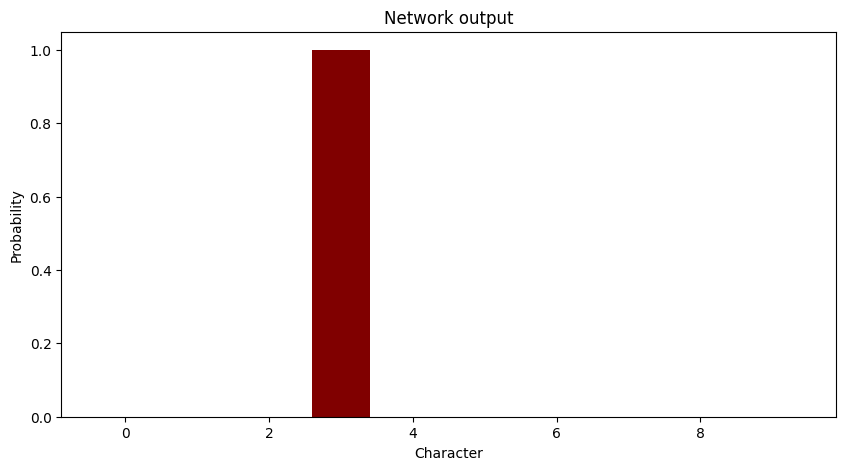

In [17]:
y_predXX = model_LR_FH2.predict((0.7*XX1,0*XX2))
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
seq = np.array([i for i in range(10)])
plt.bar(seq,y_predXX[0], color ='maroon')

plt.xlabel("Character")
plt.ylabel("Probability")
plt.title("Network output")
plt.show()